<a href="https://colab.research.google.com/github/sanikak96/Data-Science-Projects/blob/master/MusicGenreClassificationUsingMFCC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiment 3: Music Genre Classification using MFCCs

The mel frequency cepstral coefficients (MFCCs) of a signal are a small set of features (usually about 10-20) which concisely describe the overall shape of a spectral envelope. MFCCs encode timbral information and can be used to classify music by their genre. 


MFCCs are popular features used to classify music streams of short duration. This feature was used widely in many machine learning models before being used with deep learning algorithms. Many researchers have used MFCCs for audio classifcation like [Haggblade et al](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.375.204&rep=rep1&type=pdf) due to their ability to represent the audio spectrum in a compact form. 


## Importing the Necessary Libraries

In [24]:
import os
import json
import numpy as np
import librosa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import h5py 
from keras.models import load_model

## Downloading the dataset
Note: Upload the kaggle.json file before execution.

In [2]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/  #kaggle.json is my API key. 
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download andradaolteanu/gtzan-dataset-music-genre-classification
!unzip gtzan-dataset-music-genre-classification
!rm -r gtzan-dataset-music-genre-classification.zip

 99% 1.20G/1.21G [00:07<00:00, 171MB/s]
100% 1.21G/1.21G [00:07<00:00, 173MB/s]
Archive:  gtzan-dataset-music-genre-classification.zip
  inflating: Data/features_30_sec.csv  
  inflating: Data/features_3_sec.csv  
  inflating: Data/genres_original/blues/blues.00000.wav  
  inflating: Data/genres_original/blues/blues.00001.wav  
  inflating: Data/genres_original/blues/blues.00002.wav  
  inflating: Data/genres_original/blues/blues.00003.wav  
  inflating: Data/genres_original/blues/blues.00004.wav  
  inflating: Data/genres_original/blues/blues.00005.wav  
  inflating: Data/genres_original/blues/blues.00006.wav  
  inflating: Data/genres_original/blues/blues.00007.wav  
  inflating: Data/genres_original/blues/blues.00008.wav  
  inflating: Data/genres_original/blues/blues.00009.wav  
  inflating: Data/genres_original/blues/blues.00010.wav  
  inflating: Data/genres_original/blues/blues.00011.wav  
  inflating: Data/genres_original/blues/blues.00012.wav  
  inflating: Data/genres_origina

In [ ]:
# Remove corrupt file
os.remove('Data/genres_original/jazz/jazz.00054.wav')

## Experimenting with MFCCs

### Creating Dataset with Audio and MFCC

I am going to continue using the augmented audio files by chopping the original audio files into slices. However, since not all audio files are exactly 30 sec long, I am picking a duration of 29 seconds.

In [4]:
# Dataset location if the kaggle download is run
data_path = 'Data/genres_original/'

# Path where we wish to store the data after feature extraction
result_path = 'Data/data.json'

# As per my previous choice, I am pick a duration right under 30 seconds
sr = 22050
num_samples = 29 * sr

# Since the dataset contains 999 files, data augmentation is necessary.  
# Slicing the audio files:
slices = 10
samples_per_slice = int(num_samples / slices) 

In [5]:
def preprocess_data(data_path, result_path):

    # Let's create a dictionary of labels and processed data.
    feature_labels = {
        "labels": [],
        "mfcc": []
        }

    # Generating MFCCs for each audio sample after slicing it
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(data_path)):

        for file in filenames:
            song, sr = librosa.load(os.path.join(dirpath, file), duration=29)

            for s in range(slices):
                start_sample = samples_per_slice * s
                end_sample = start_sample + samples_per_slice
                mfcc = librosa.feature.mfcc(y=song[start_sample:end_sample], sr=sr, n_mfcc=13) #13 bands MFCCs
                mfcc = mfcc.T
                feature_labels["labels"].append(i-1)
                feature_labels["mfcc"].append(mfcc.tolist())

    # Saving the data to a .json file for future use.    
    with open(result_path, 'w') as f:
        json.dump(feature_labels, f)
    f.close()

### Loading data into numpy arrays for TensorFlow compatibility.


In [6]:
def load_data(result_path):

    with open(result_path, 'r') as f:
        data = json.load(f)
    f.close()
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    print(X.shape)

    return X, y

#### Function to create Train, Test and Valdiation Split

In [7]:
def prepare_datasets(X, y, split_size):
    
    # Creating a validation set and a test set.
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=split_size,random_state=0)
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=split_size,random_state=0)
    
    # Our CNN model expects 3D input shape.
    X_train = X_train[..., np.newaxis]
    X_val = X_val[..., np.newaxis]
    X_test = X_test[..., np.newaxis]
    
    return X_train, X_val, X_test, y_train, y_val, y_test

#### Defining a model:
The model contains 3 convolutional layers and one dense layers (i.e. 4 hidden layers), one input and one output layer. I have applied max pooling with a filter size of 3 x 3. The stride (2,2) indicates the two values related to the two dimensions x and y along which we move the filters. 

Each of the 2D convolution layers have 32 neurons. In order to optimize the model, a dropout layer has been added. A dropout of 0.3 means we drop 3% neurons randomly as a regularization method and avoid overfitting.

In [8]:
def genre_model(input_shape):
    model = tf.keras.models.Sequential([
        
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Conv2D(32, (2,2), activation='relu'),
        tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'), 
        tf.keras.layers.Dense(len(np.unique(targets)), activation='softmax')
    ])

    return model

In [9]:
def make_prediction(model, X, y, idx):
    
    genre_dict = {
        0 : "blues",
        1 : "classical",
        2 : "country",
        3 : "disco",
        4 : "hiphop",
        5 : "jazz",
        6 : "metal",
        7 : "pop",
        8 : "reggae",
        9 : "rock",
        }
        
    predictions = model.predict(X)
    genre = np.argmax(predictions[idx])
    
    print("\nThe model predicts: {}, and ground truth is: {}.\n".format(genre_dict[genre], genre_dict[y[idx]]))

In [10]:
def plot_performance(hist):
    
    acc = hist.history['acc']
    val_acc = hist.history['val_acc']
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [13]:
preprocess_data(data_path, result_path)
inputs, targets = load_data(result_path)

(9990, 125, 13)


In [14]:
X_train, X_val, X_test, y_train, y_val, y_test = prepare_datasets(inputs, targets, 0.2)
print(X_train.shape)
input_shape = (X_train.shape[1], X_train.shape[2], 1)
print(input_shape)

(6393, 125, 13, 1)
(125, 13, 1)


In [15]:
model = genre_model(input_shape)

# Selection of the optimizer, loss type and metrics for performance evaluation.
model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.0005),
                     loss='sparse_categorical_crossentropy',
                     metrics = ['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 123, 11, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 6, 32)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 62, 6, 32)        128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 4, 32)         9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 2, 32)        0         
 2D)                                                             
                                                        

Epoch 1/30
200/200 [==============================] - 15s 13ms/step - loss: 1.7496 - acc: 0.4040 - val_loss: 1.6230 - val_acc: 0.4384
Epoch 2/30
200/200 [==============================] - 2s 10ms/step - loss: 1.2792 - acc: 0.5445 - val_loss: 1.1300 - val_acc: 0.6016
Epoch 3/30
200/200 [==============================] - 2s 10ms/step - loss: 1.0865 - acc: 0.6052 - val_loss: 1.0091 - val_acc: 0.6446
Epoch 4/30
200/200 [==============================] - 2s 11ms/step - loss: 0.9647 - acc: 0.6568 - val_loss: 0.8836 - val_acc: 0.6992
Epoch 5/30
200/200 [==============================] - 2s 10ms/step - loss: 0.8894 - acc: 0.6883 - val_loss: 0.8524 - val_acc: 0.7132
Epoch 6/30
200/200 [==============================] - 2s 11ms/step - loss: 0.8183 - acc: 0.7112 - val_loss: 0.7925 - val_acc: 0.7237
Epoch 7/30
200/200 [==============================] - 2s 11ms/step - loss: 0.7654 - acc: 0.7281 - val_loss: 0.7291 - val_acc: 0.7503
Epoch 8/30
200/200 [==============================] - 2s 11ms/step -

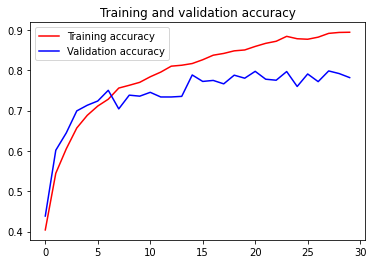

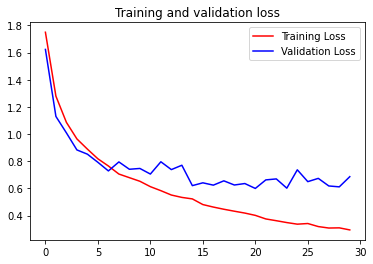

In [17]:
# Training the model.
history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=30,
                        batch_size=32)

plot_performance(history)


#### Testing the model on never seen before data.

In [18]:
make_prediction(model, X_test, y_test, 24)


The model predicts: classical, and ground truth is: classical.



#### Saving the Model

In [25]:
# save model
model.save('genreModelMfcc.h5')
print('Model Saved!')

# load model
savedModel=load_model('genreModelMfcc.h5')
savedModel.summary()

Model Saved!
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 123, 11, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 6, 32)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 62, 6, 32)        128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 4, 32)         9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 2, 32)        0         
 2D)                                                             
                                           

In [27]:
make_prediction(savedModel, X_test, y_test, 105)


The model predicts: reggae, and ground truth is: reggae.



### Results

On using this model, I am able to get a training accuracy of 89% and a validation accuracy of about 78%.



**Conclusion**:

As per [Li et al.](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.1061.2271&rep=rep1&type=pdf), MFCCs encode timbral and key information. Music Genre are supposed to be invariant to keys but are not. As a result, mel spectrograms can prove to be a better feature. 

Alternative approach can be to build a model that can counter this shortcoming since generating MFCC features is less resource intensive and can give a good accuracy.


**Future Work**: 

Machine learning models can be compared to neural network models using MFCCs as a feature. Apart from this, different model architectures tried and hyper parameter tuning on these models to achieve better accuracy.
